In [1]:
import torch
import torch.nn as nn
import numpy as np
from scipy import linalg
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

from model_cond import model as model_cond, sample as sample_cond
from model_uncond import model as model_uncond, sample as sample_uncond

In [2]:
model_cond.load_state_dict(torch.load(r"diff_weights/cond_ema_model_epoch_400.pt"))
model_uncond.load_state_dict(torch.load(r"diff_weights/200_cos_model_epoch_300.pt"))

<All keys matched successfully>

In [3]:

# --- Load LeNet  ---
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x, return_features=False):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        features = self.fc1(x)
        if return_features:
            return features
        return self.fc2(features)

# --- Fréchet Distance ---
def frechet_distance(mu1, sigma1, mu2, sigma2):
    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1 @ sigma2, disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)

# --- Extract features from dataset ---
def extract_features(model, data_loader, device):
    model.eval()
    feats = []
    with torch.no_grad():
        for x, _ in tqdm(data_loader):
            x = x.to(device)
            feat = model(x, return_features=True).cpu()
            feats.append(feat)
    return torch.cat(feats, dim=0).numpy()

# --- FID between two sets of features ---
def compute_fid(feats1, feats2):
    mu1, sigma1 = np.mean(feats1, axis=0), np.cov(feats1, rowvar=False)
    mu2, sigma2 = np.mean(feats2, axis=0), np.cov(feats2, rowvar=False)
    return frechet_distance(mu1, sigma1, mu2, sigma2)

# --- Dataset wrapper for generated samples ---
mnist_normalize = transforms.Normalize((0.1307,), (0.3081,))

class GeneratedDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples
        self.transform = mnist_normalize

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x = self.samples[idx]
        x = self.transform(x)
        return x, 0  # dummy label

# --- Main FID Evaluation ---
def evaluate_fid(real_loader, generated_samples, model_path, device):
    model = LeNet().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))

    generated_samples = generated_samples.clamp(0, 1).cpu()
    generated_loader = DataLoader(GeneratedDataset(generated_samples), batch_size=128, shuffle=False)

    feats_real = extract_features(model, real_loader, device)
    feats_fake = extract_features(model, generated_loader, device)

    fid_score = compute_fid(feats_real, feats_fake)
    print(f"FID: {fid_score:.2f}")
    return fid_score



In [4]:

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 128

# Real MNIST loader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
real_dataset = datasets.MNIST('./data', train=False, transform=transform)
real_loader = DataLoader(real_dataset, batch_size=BATCH_SIZE, shuffle=False)

samples_uncond = sample_uncond(model_uncond, n_samples=10000)
samples_cond = sample_cond(model_cond, n_samples=10000)

print('unconditional model:')
evaluate_fid(real_loader, samples_uncond, 'lenet_mnist.pth', DEVICE)

print('conditional model:')
evaluate_fid(real_loader, samples_cond, 'lenet_mnist.pth', DEVICE)

unconditional model:


100%|██████████| 79/79 [00:00<00:00, 240.75it/s]


FID: 34.85
conditional model:


100%|██████████| 79/79 [00:00<00:00, 240.74it/s]

FID: 6.59


6.590008687591283

### Conditional results

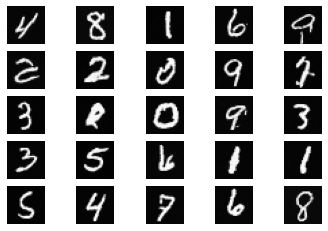

In [7]:
num_rows = 5
num_col = 5

samples_cond = sample_cond(model_cond, n_samples=num_rows*num_col).cpu().detach()

for i in range(num_rows*num_col):
    plt.subplot(num_rows, num_col, i+1)
    plt.imshow(samples_cond[i, 0], cmap='gray')
    plt.axis('off')
plt.show()

### Unconditional results

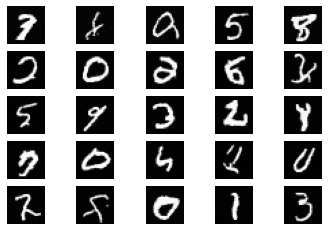

In [8]:
num_rows = 5
num_col = 5

samples_uncond = sample_uncond(model_uncond, n_samples=num_rows*num_col).cpu().detach()

for i in range(num_rows*num_col):
    plt.subplot(num_rows, num_col, i+1)
    plt.imshow(samples_uncond[i, 0], cmap='gray')
    plt.axis('off')
plt.show()